# Model Training

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    TrainerCallback
)
import evaluate
import torch
from torch.nn import BCEWithLogitsLoss
from typing import Optional, Dict
from torch import FloatTensor, tensor
import logging
from sklearn.metrics import classification_report, hamming_loss
from transformers import EvalPrediction

In [2]:
# for uploading model to hub
from huggingface_hub import notebook_login

notebook_login()

## Dataset Preparation

Will be training 3 datasets and comparing performances:
1. original goEmotions dataset
2. goEmotions + other datasets
3. goEmotions + other datasets + textattack data augmentation

In [3]:
random_seed = 1234

In [4]:
labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

label2id = {label:idx for idx, label in enumerate(labels)}
id2label = {idx:label for idx, label in enumerate(labels)}

### Load base model and tokenizer

In [5]:
model_name = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),     
    problem_type="multi_label_classification", # uses BCEWithLogitsLoss by default)
    id2label=id2label,
    label2id=label2id
) 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# padding will be dynamically done in batching with DataCollatorWithPadding
def tokenize_func(examples):
    return tokenizer(examples['text'], truncation=True)

### Load datasets
Will be training 3 different datasets
- goEmotions (go)
- goEmotions + other datasets (merged)
- goEmotions + other datasets + textattack data augmentation (augmented)

In [7]:
# go
# dataset = load_from_disk('./datasets/cleaned_hf/goEmotions_cleaned')
# # merged
# dataset = load_from_disk('./datasets/cleaned_hf/merged_hf')
# augmented
# dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf')

In [8]:
# augmented v2
dataset = load_from_disk('./datasets/cleaned_hf/augmented_hf_v2')

In [9]:
type(dataset['train']['labels'][1][0])

int

In [ ]:
# In order to use BCEWithLogitsLoss, we need to convert labels to float or it'll give errors
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
# https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3
dataset = dataset.cast_column('labels', Sequence(feature=Value(dtype='float32')))

In [11]:
type(dataset['train']['labels'][1][6])

float

In [12]:
# before shuffle
dataset['train']['text'][:5]

['following people around, though there are so many.. where are the webdesign twitters!',
 'i have to admit that i fact feeling distracted by the was that i was blocking traffic',
 "It's Shrimpy ( I'm pretty happy with it and the telegram is decently alive active too",
 'Love live [NAME]',
 "@AllanCavanagh I'd move into a mudhut if I could. But none of the other crap. I just like the mudhut"]

In [13]:
# shuffle training set
dataset['train'] = dataset['train'].shuffle(seed=random_seed)

In [14]:
# after shuffle
dataset['train']['text'][:5]

['i was told it make my arms go numb but i didnt feel anything numb about it as they pricked my arm with their so called baby ',
 '*Whispers* ... ‘they are everywhere.’',
 'Weird, Tuxedo Mask looks shorter and pudgier than I pictured him to be',
 "dude right your gonna make me cry. This is horrible please don't do this STOP stop now. Dont it's just not worth it",
 'i am feeling pleasant']

#### Calculate Class Weights

In [15]:
from generate_class_weights import generate_class_weights 

In [16]:
class_weights = generate_class_weights(dataset['train']['labels'], multi_class=False, one_hot_encoded=True)
class_weights

{0: 0.6597870963227319,
 1: 1.1715202062560184,
 2: 0.4260157688441076,
 3: 1.1205951390539577,
 4: 0.9492285814960234,
 5: 1.9166920770442648,
 6: 1.5237051551389786,
 7: 1.263560372554275,
 8: 3.212773660448079,
 9: 1.6557533585038196,
 10: 1.3692049373752042,
 11: 0.796897120037188,
 12: 6.594640671446057,
 13: 2.4258538624815076,
 14: 0.7155141339404287,
 15: 1.0146556362658057,
 16: 26.805081734186214,
 17: 0.2906836486955181,
 18: 0.3796646768072319,
 19: 12.858762359359018,
 20: 0.7607768184935652,
 21: 20.10381130063966,
 22: 1.9194233803246985,
 23: 1.330326278659612,
 24: 3.65028552071235,
 25: 0.22273849388446934,
 26: 0.7188554274278091,
 27: 0.25533488595665743}

#### Tokenization

In [17]:
# tokenize in batch
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset

Map:   0%|          | 0/10426 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 150859
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12721
    })
})

#### Batching and Dynamic padding

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Training
- Will be using `Trainer` instead of `SFTTrainer` because `SFTTrainer` is often for llms.

In [19]:
training_args = TrainingArguments(
    './models/augmented_v2',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="no",
    push_to_hub=True,
    hub_private_repo=True,
    hub_model_id="augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v2"
    )

#### Compute metrics function

In [20]:
# sources: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    
    # Generate classification report
    report = classification_report(
        y_true=labels,
        y_pred=y_pred,
        output_dict=True,  # Convert report to a dictionary
        zero_division=0  # Avoid division errors for missing labels
    )

    # Extract key metrics
    micro_precision = report["micro avg"]["precision"]
    micro_recall = report["micro avg"]["recall"]
    micro_f1 = report["micro avg"]["f1-score"]

    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    weighted_precision = report["weighted avg"]["precision"]
    weighted_recall = report["weighted avg"]["recall"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    hamming = hamming_loss(y_true, y_pred)

    # Combine all metrics into a dictionary
    metrics = {
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "weighted_f1": weighted_f1,
        "hamming_loss": hamming
    }

    return metrics



def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result
    

#### Custom Class Weighting Trainer Class

In [21]:
# Reference: https://discuss.huggingface.co/t/mullti-label-text-classification/44233/3
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights: Optional[Dict[int, float]] = None, processing_class: Optional[AutoTokenizer] = None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            # dict --> FloatTensor
            if isinstance(class_weights, dict):
                # Convert to list of values and then to FloatTensor
                class_weights = tensor(list(class_weights.values()), dtype=torch.float)
                logging.info(f"Converted class_weights to FloatTensor: {class_weights}")
            elif not isinstance(class_weights, FloatTensor):
                raise ValueError("class_weights must be a dict or a FloatTensor")
            class_weights = class_weights.to(self.args.device)

        self.loss_fct = BCEWithLogitsLoss(pos_weight=class_weights)

        # If processing_class is passed, use it
        if processing_class is not None:
            self.processing_class = processing_class  # Handling tokenizer using processing_class argument
        else:
            self.processing_class = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        try:
            loss = self.loss_fct(outputs.logits.view(-1, model.num_labels), labels.view(-1, model.num_labels))
        except AttributeError:  # DataParallel
            loss = self.loss_fct(outputs.logits.view(-1, model.module.num_labels), labels.view(-1, model.num_labels))

        return (loss, outputs) if return_outputs else loss

### Train and Validation

In [22]:
# train_subset = tokenized_dataset["train"].select(range(100))
# eval_subset = tokenized_dataset["validation"].select(range(100))

In [23]:
trainer = WeightedTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

  0%|          | 0/56574 [00:00<?, ?it/s]

c:\Users\skpar\Desktop\Learning\ml\.env\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.0744575634598732, 'eval_micro_precision': 0.7527865774961868, 'eval_micro_recall': 0.5168774671715137, 'eval_micro_f1': 0.6129155521589607, 'eval_macro_precision': 0.6154822396354037, 'eval_macro_recall': 0.38047302896942303, 'eval_macro_f1': 0.43364791510494216, 'eval_weighted_precision': 0.7385646552722177, 'eval_weighted_recall': 0.5168774671715137, 'eval_weighted_f1': 0.5826862005559039, 'eval_hamming_loss': 0.0277602696555315, 'eval_runtime': 26.2678, 'eval_samples_per_second': 396.911, 'eval_steps_per_second': 49.642, 'epoch': 1.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.07567515224218369, 'eval_micro_precision': 0.7101670741646292, 'eval_micro_recall': 0.5615886570530895, 'eval_micro_f1': 0.6271987043951595, 'eval_macro_precision': 0.5936542694755119, 'eval_macro_recall': 0.46575324890947456, 'eval_macro_f1': 0.5048526190698179, 'eval_weighted_precision': 0.6977735943668754, 'eval_weighted_recall': 0.5615886570530895, 'eval_weighted_f1': 0.610518207958515, 'eval_hamming_loss': 0.028387136554218848, 'eval_runtime': 26.0123, 'eval_samples_per_second': 400.81, 'eval_steps_per_second': 50.13, 'epoch': 2.0}


  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.07923083752393723, 'eval_micro_precision': 0.6921977707916548, 'eval_micro_recall': 0.5853540642874406, 'eval_micro_f1': 0.6343081623745089, 'eval_macro_precision': 0.5809169914805398, 'eval_macro_recall': 0.472894445938355, 'eval_macro_f1': 0.5135700982539695, 'eval_weighted_precision': 0.6763562600814358, 'eval_weighted_recall': 0.5853540642874406, 'eval_weighted_f1': 0.6237658097933914, 'eval_hamming_loss': 0.028698857252473214, 'eval_runtime': 26.9331, 'eval_samples_per_second': 387.107, 'eval_steps_per_second': 48.416, 'epoch': 3.0}
{'train_runtime': 4608.2938, 'train_samples_per_second': 98.209, 'train_steps_per_second': 12.277, 'train_loss': 0.06838087011176733, 'epoch': 3.0}


TrainOutput(global_step=56574, training_loss=0.06838087011176733, metrics={'train_runtime': 4608.2938, 'train_samples_per_second': 98.209, 'train_steps_per_second': 12.277, 'total_flos': 4289819946078264.0, 'train_loss': 0.06838087011176733, 'epoch': 3.0})

In [25]:
# https://youtu.be/Zh0FfmVrKX0?t=147
# push to hub again b/c:
# 1. making sure we are uploading the final version of the model if we didn't already
# 2. draft a model card in the landing page of model repo
trainer.push_to_hub("End of training")

CommitInfo(commit_url='https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v2/commit/2849361e211fe8e6a48554c54dc3d0a91def04f7', commit_message='End of training', commit_description='', oid='2849361e211fe8e6a48554c54dc3d0a91def04f7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='paradoxmaske/augmented-go-emotions-plus-other-datasets-fine-tuned-distilroberta-v2'), pr_revision=None, pr_num=None)

In [26]:
# validation evaluation
trainer.evaluate()

  0%|          | 0/1304 [00:00<?, ?it/s]

{'eval_loss': 0.07923083752393723,
 'eval_micro_precision': 0.6921977707916548,
 'eval_micro_recall': 0.5853540642874406,
 'eval_micro_f1': 0.6343081623745089,
 'eval_macro_precision': 0.5809169914805398,
 'eval_macro_recall': 0.472894445938355,
 'eval_macro_f1': 0.5135700982539695,
 'eval_weighted_precision': 0.6763562600814358,
 'eval_weighted_recall': 0.5853540642874406,
 'eval_weighted_f1': 0.6237658097933914,
 'eval_hamming_loss': 0.028698857252473214,
 'eval_runtime': 26.167,
 'eval_samples_per_second': 398.44,
 'eval_steps_per_second': 49.834,
 'epoch': 3.0}

#### Evaluate on test

In [27]:
# test_subset = tokenized_dataset["test"].select(range(100))

In [28]:
logits, true_labels, metrics = trainer.predict(tokenized_dataset['test'])
metrics

  0%|          | 0/1591 [00:00<?, ?it/s]

{'test_loss': 0.0869712233543396,
 'test_micro_precision': 0.708412354375508,
 'test_micro_recall': 0.601506786289395,
 'test_micro_f1': 0.6505971634735008,
 'test_macro_precision': 0.5499252047765284,
 'test_macro_recall': 0.46396127365711226,
 'test_macro_f1': 0.4966865572806488,
 'test_weighted_precision': 0.698909847951002,
 'test_weighted_recall': 0.601506786289395,
 'test_weighted_f1': 0.6442093680291345,
 'test_hamming_loss': 0.03153952407155772,
 'test_runtime': 31.5131,
 'test_samples_per_second': 403.674,
 'test_steps_per_second': 50.487}

In [29]:
# change logits to pred array
threshold = 0.5
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))
# next, use threshold to turn them into integer predictions
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1
y_pred

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
report = classification_report(true_labels, y_pred, target_names=labels, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

    admiration       0.65      0.66      0.66       504
     amusement       0.71      0.84      0.77       264
         anger       0.80      0.70      0.74      1585
     annoyance       0.44      0.25      0.32       320
      approval       0.47      0.32      0.38       351
        caring       0.37      0.31      0.34       135
     confusion       0.41      0.42      0.42       153
     curiosity       0.50      0.42      0.46       284
        desire       0.47      0.35      0.40        83
disappointment       0.31      0.16      0.21       151
   disapproval       0.42      0.29      0.35       267
       disgust       0.72      0.63      0.67      1222
 embarrassment       0.52      0.35      0.42        37
    excitement       0.43      0.39      0.41       103
          fear       0.79      0.76      0.78       787
     gratitude       0.92      0.89      0.90       352
         grief       0.

Confusion Matrix for label admiration:
[[12035   182]
 [  169   335]]


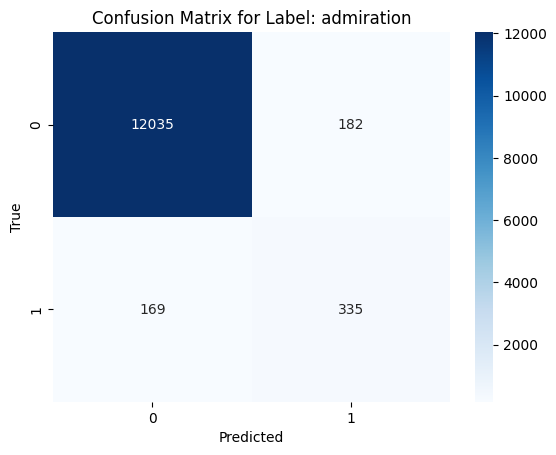

Confusion Matrix for label amusement:
[[12366    91]
 [   43   221]]


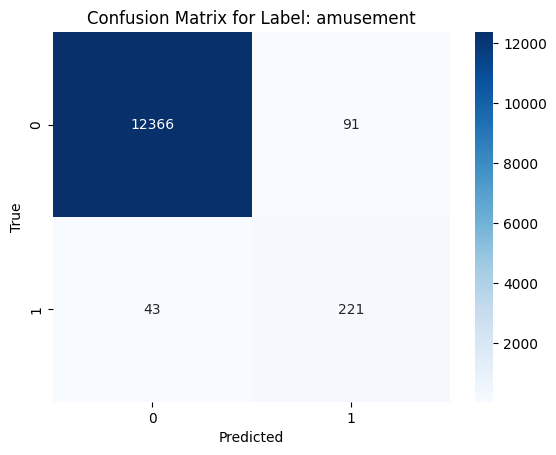

Confusion Matrix for label anger:
[[10862   274]
 [  482  1103]]


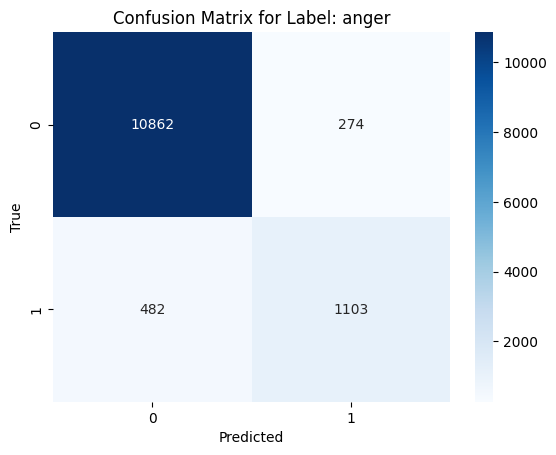

Confusion Matrix for label annoyance:
[[12301   100]
 [  241    79]]


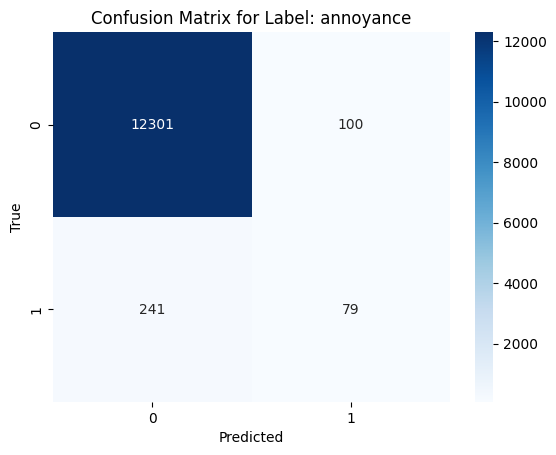

Confusion Matrix for label approval:
[[12245   125]
 [  240   111]]


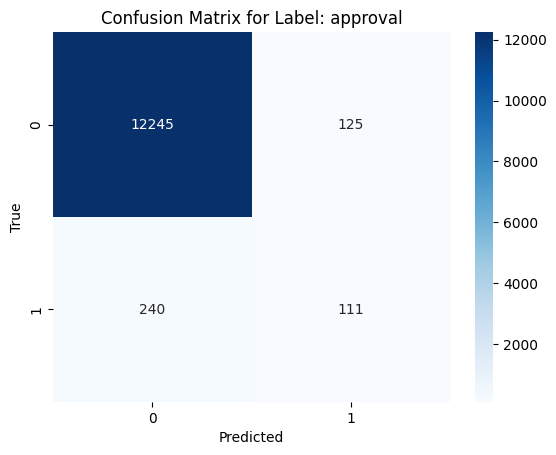

Confusion Matrix for label caring:
[[12514    72]
 [   93    42]]


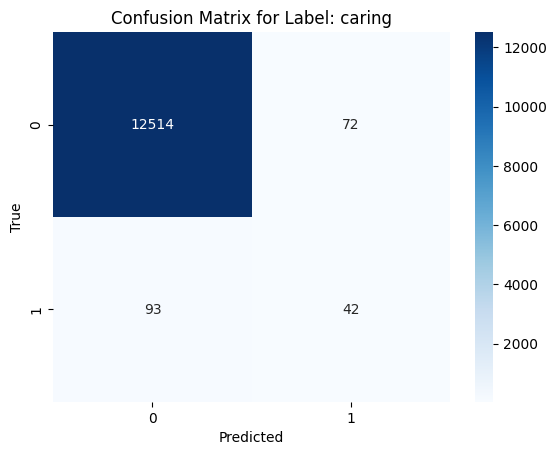

Confusion Matrix for label confusion:
[[12476    92]
 [   88    65]]


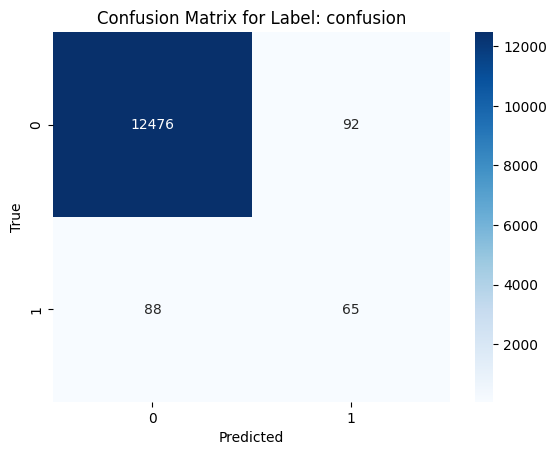

Confusion Matrix for label curiosity:
[[12318   119]
 [  165   119]]


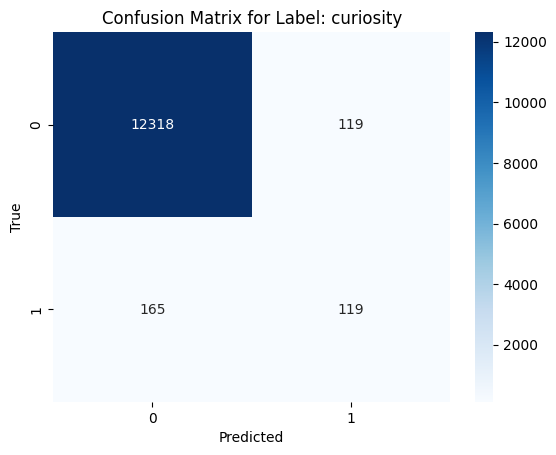

Confusion Matrix for label desire:
[[12605    33]
 [   54    29]]


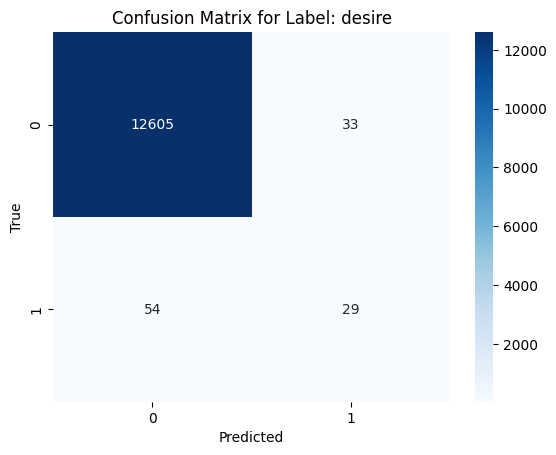

Confusion Matrix for label disappointment:
[[12517    53]
 [  127    24]]


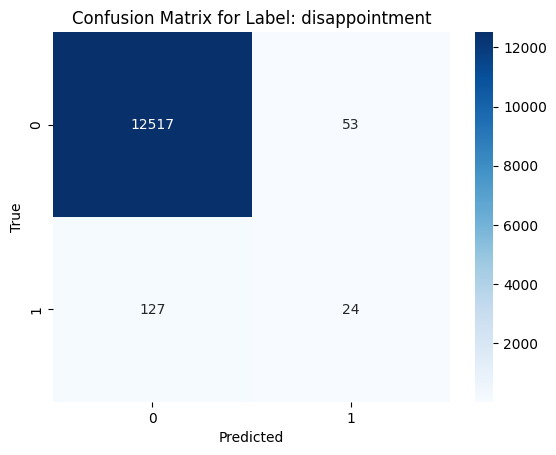

Confusion Matrix for label disapproval:
[[12348   106]
 [  189    78]]


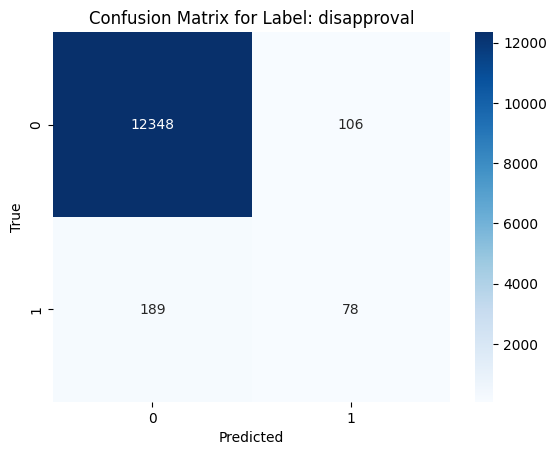

Confusion Matrix for label disgust:
[[11198   301]
 [  458   764]]


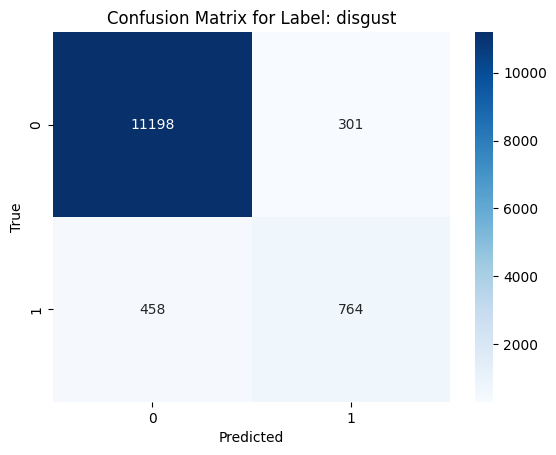

Confusion Matrix for label embarrassment:
[[12672    12]
 [   24    13]]


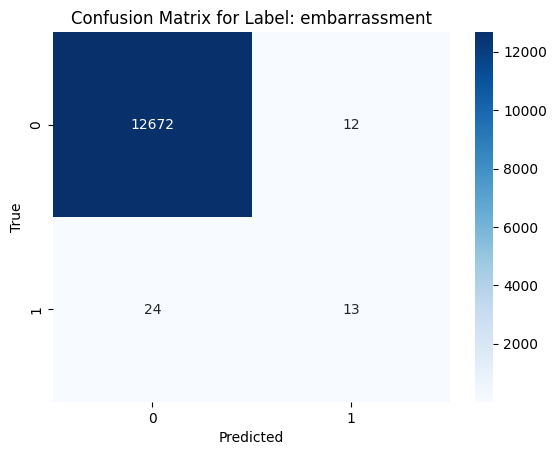

Confusion Matrix for label excitement:
[[12564    54]
 [   63    40]]


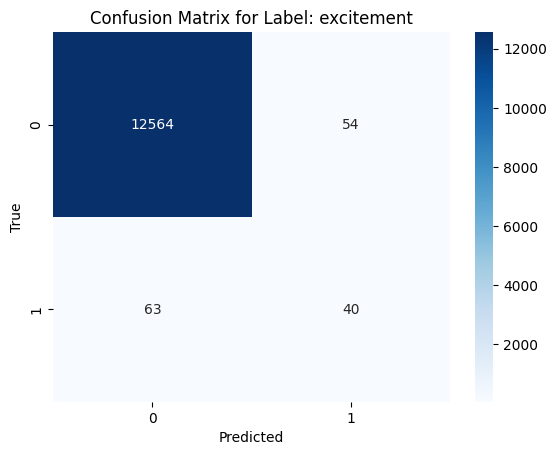

Confusion Matrix for label fear:
[[11772   162]
 [  185   602]]


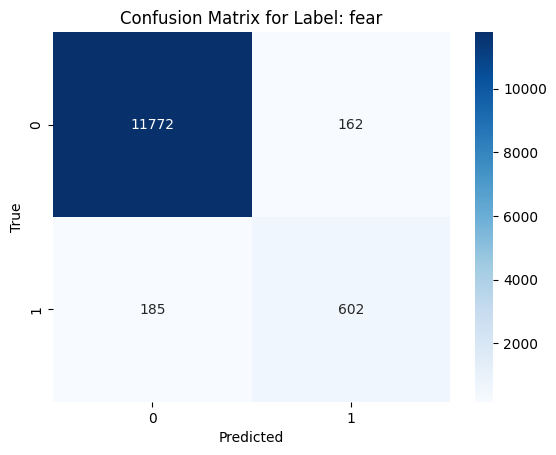

Confusion Matrix for label gratitude:
[[12341    28]
 [   38   314]]


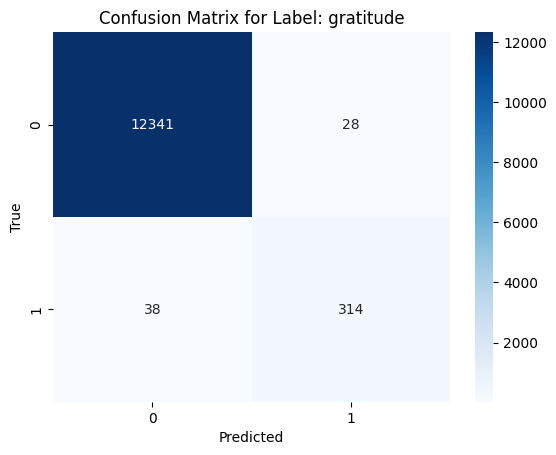

Confusion Matrix for label grief:
[[12715     0]
 [    6     0]]


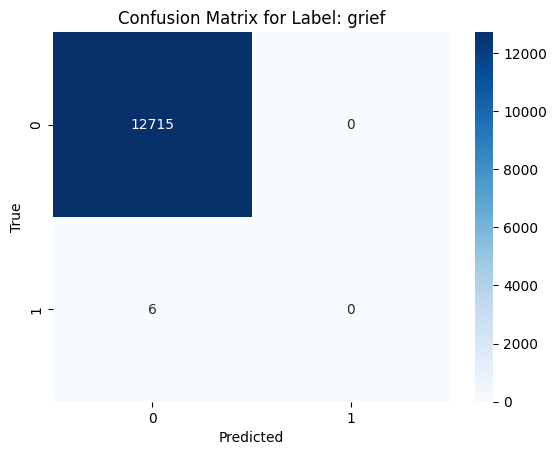

Confusion Matrix for label joy:
[[10150   273]
 [  535  1763]]


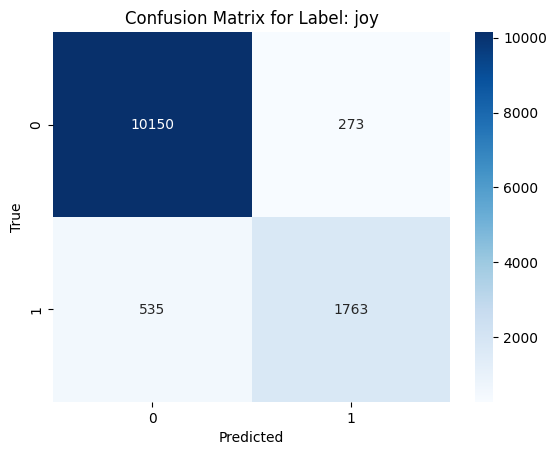

Confusion Matrix for label love:
[[11058   358]
 [  512   793]]


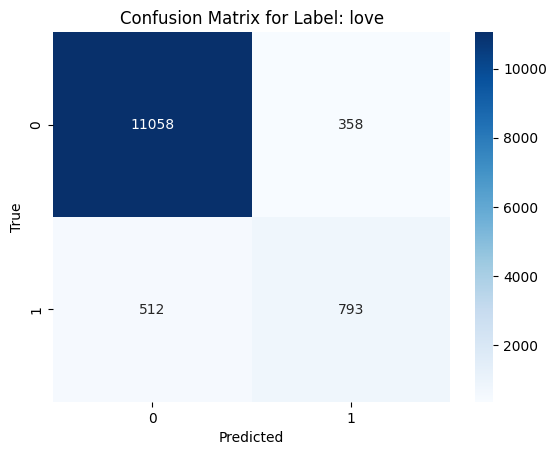

Confusion Matrix for label nervousness:
[[12690     8]
 [   17     6]]


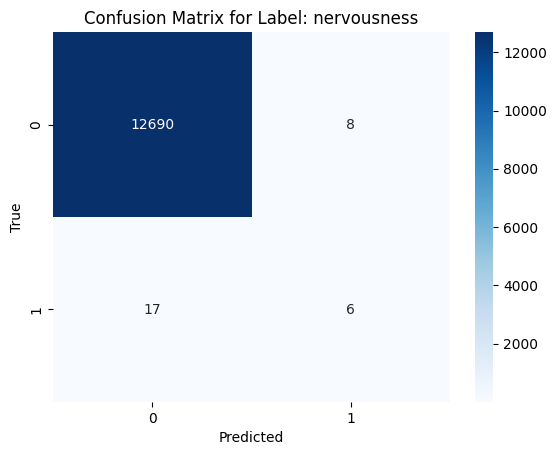

Confusion Matrix for label optimism:
[[11091   301]
 [  569   760]]


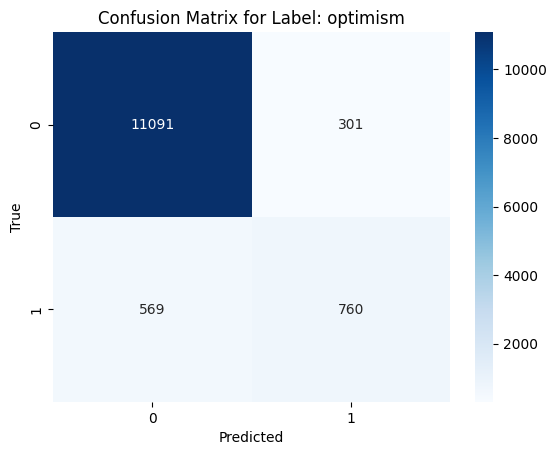

Confusion Matrix for label pride:
[[12702     3]
 [   11     5]]


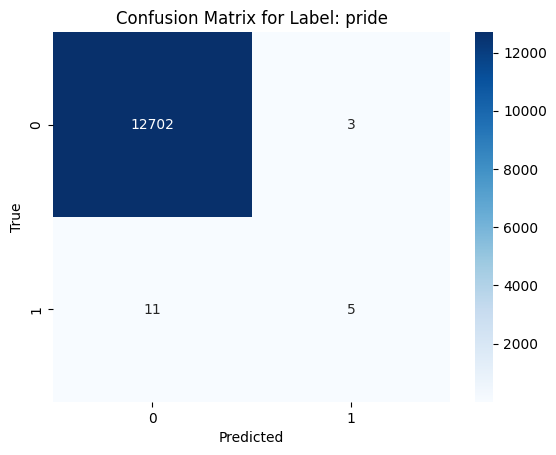

Confusion Matrix for label realization:
[[12533    43]
 [  117    28]]


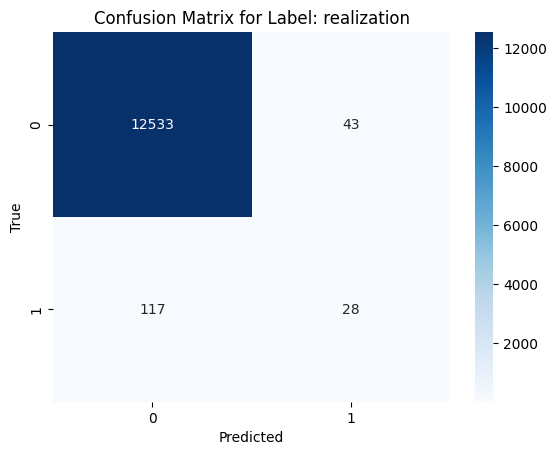

Confusion Matrix for label relief:
[[12452   109]
 [  121    39]]


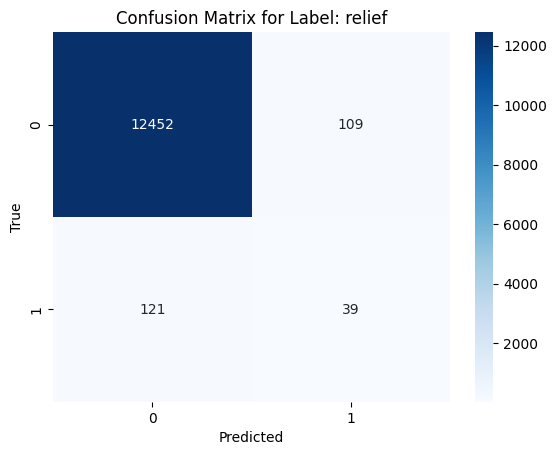

Confusion Matrix for label remorse:
[[12632    33]
 [   14    42]]


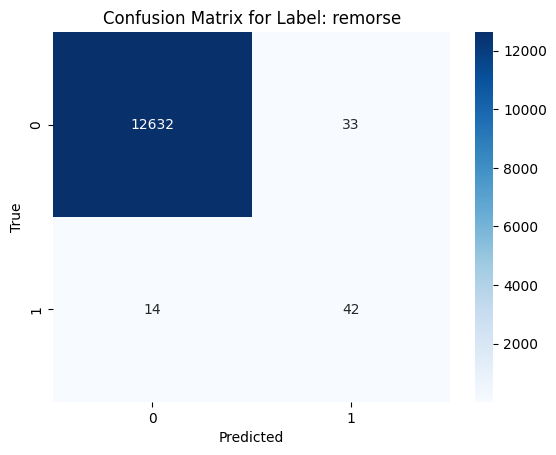

Confusion Matrix for label sadness:
[[9993  516]
 [ 685 1527]]


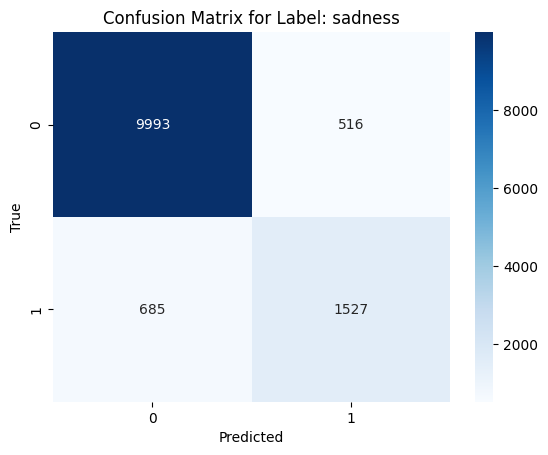

Confusion Matrix for label surprise:
[[11962   187]
 [  374   198]]


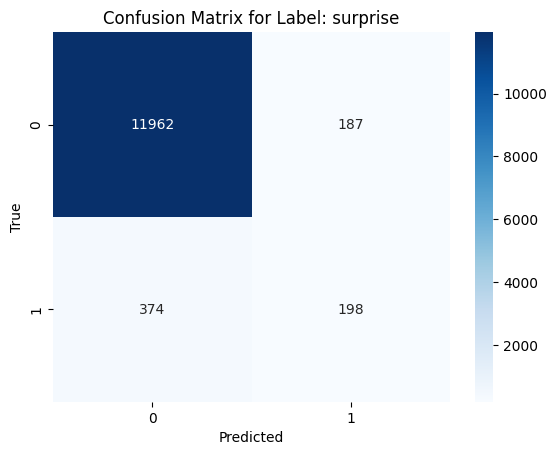

Confusion Matrix for label neutral:
[[9383  670]
 [1309 1359]]


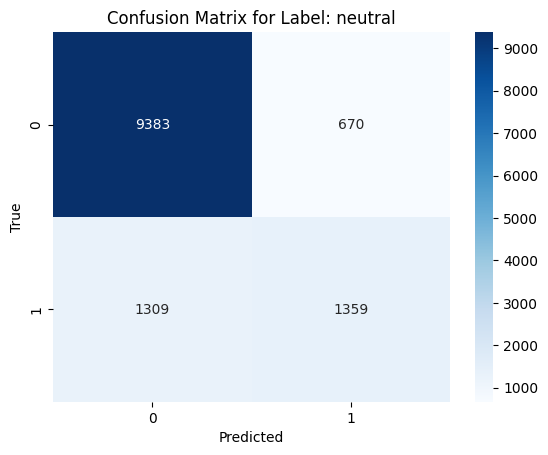

In [31]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mcm = multilabel_confusion_matrix(true_labels, y_pred)

for i in range(mcm.shape[0]):
    print(f"Confusion Matrix for label {labels[i]}:")
    print(mcm[i])
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for Label: {labels[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()